In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hottbox.core import Tensor, TensorTKD
from hottbox.algorithms.decomposition import HOSVD, HOOI
from hottbox.utils.generation import residual_tensor
from coursework.data import get_image, plot_tensors

In [3]:
np.random.seed(0)

[Return to Table of Contents](./0_Table_of_contents.ipynb)

# Tucker Decomposition

<img src="./imgs/TensorTKD.png" alt="Drawing" style="width: 500px;"/>

In previous [assignment](./2_Efficient_representation_of_multidimensional_arrays.ipynb), you have been provided materials which cover efficient representations of mutlidimensional arrays of data, such as the Tucker form. In this module, you will take a closer look at it and the assiciated computational methods.


Any tensor of arbitrarily large order can be decomposed in the Tucker form. As illustrated above, a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I \times J \times K}$ can be represented as a dense core tensor $\mathbf{\underline{G}}$ and a set of factor matrices $\mathbf{A} \in \mathbb{R}^{I \times Q}, \mathbf{B} \in \mathbb{R}^{J \times R}$ and $\mathbf{C} \in
\mathbb{R}^{K \times P}$

$$
\mathbf{\underline{X}} = \mathbf{\underline{G}} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = \Big[    \mathbf{\underline{G}} ;  \mathbf{A},  \mathbf{B}, \mathbf{C}      \Big]
$$


On practice, there exist several computational methods to accomplish this all of which are combined into a Tucker Decomposition framework. The two most commonly used algorithms are:
1. Higher Order Singular Value Decomposition ([HOSVD](#Higher-Order-Singular-Value-Decomposition-(HOSVD)))
1. Higher Order Orthogonal Iteration ([HOOI](#Higher-Order-Orthogonal-Iteration-(HOOI)))


# Higher Order Singular Value Decomposition (HOSVD)

The HOSVD is a special case of the Tucker decomposition, in which all the factor matrices are constrained to be orthogonal. They are computed as truncated version of the left singular matrices of all possible mode-$n$ unfoldings of tensor $\mathbf{\underline{X}}$:

$$
\begin{aligned}
\mathbf{X}_{(1)} &= \mathbf{U}_1  \mathbf{\Sigma}_1 \mathbf{V}_1^T \quad \rightarrow \quad \mathbf{A} = \mathbf{U}_1[1:R_1]\\
\mathbf{X}_{(2)} &= \mathbf{U}_2  \mathbf{\Sigma}_2 \mathbf{V}_2^T \quad \rightarrow \quad \mathbf{B} = \mathbf{U}_2[1:R_2] \\
\mathbf{X}_{(3)} &= \mathbf{U}_3  \mathbf{\Sigma}_3 \mathbf{V}_3^T \quad \rightarrow \quad \mathbf{C} = \mathbf{U}_3[1:R_3] \\
\end{aligned}
$$

After factor matrices are obtained, the core tensor $\mathbf{\underline{G}}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^T \times_2 \mathbf{B}^T \times_3 \mathbf{C}^T        
$$


# Higher Order Orthogonal Iteration (HOOI)

HOOI algorithm is another special case of the Tuker decomposition. Like HOSVD, it decomposes a tensor into a dense core tensor and orthogonal factor matrices. The difference between the two lies in the fact that in HOOI the factor matrices are optimized iteratively using an Alternating Least Squares (ALS) approach. In other words, the tucker representation $[ \mathbf{\underline{G}};\mathbf{A}^{(1)}, \mathbf{A}^{(2)}, \cdots,\mathbf{A}^{(N)} ]$ of the given tensor $\mathbf{\underline{X}}$ is obtained through the HOOI as follows

$$
\begin{aligned}
&\mathbf{\underline{Y}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T} \times_2 \cdots \times_{n-1} \mathbf{A}^{(n-1)T} \times_{n+1} \mathbf{A}^{(n+1)} \times \cdots \times_N \mathbf{A}^{(N)} \\
&\mathbf{A}^{(n)} \leftarrow R_n \text{ leftmost singular vectors of } \mathbf{Y}_{(n)}
\end{aligned}
$$

The above is repeated until convergence, then the core tensor $\mathbf{\underline{G}} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T}  \times_2 \mathbf{A}^{(2)T} \times_3 \cdots  \times_N \mathbf{A}^{(N)T}
$$

# Multi-linear rank

The **multi-linear rank** of a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Thus, for our order-$3$ tensor the multi-linear rank is $(R_1, R_2, R_3)$. Multi-linear rank provides flexibility in compression and approximation of the original tensor.

> **NOTE:** For a tensor of order $N$ the values $R_1, R_2, \dots , R_N$ are not necessarily the same, whereas, for matrices (tensors of order 2) the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the matrix column rank and row rank respectively.



# Performing tensor decomposition

In [4]:
# Create tensor
I, J, K = 5, 6, 7
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float)
tensor = Tensor(array_3d)

# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 5, 6)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 5, 6).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (5, 6, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (6, 5)
Mode-2 factor matrix is of shape (7, 6)

	Core tensor
This tensor is of order 3 and consists of 120 elements.
Sizes and names of its modes are (4, 5, 6) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Evaluation and reconstruction

Tucker representation of an original tensor is almost always an approximation, regardless of which algorithm has been employed for performing decomposition. Thus, relative error of approximation is commonly used in order to evaluate performance of computational methods, i.e. the ratio between a Frobenious norms of residual and original tensors.

In [5]:
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.2132026456161808


## **Assigment 1**

1. Create a tensor of order 4 with sizes of each mode being defined by prime numbers and  obtain a Tucker representation using HOOI algorithm with multi-linear (4, 10, 6, 2). Then calculation ratio between the number of elements in the original tensor and its Tucker form.

1. For a tensor that consists of 1331 elements, which multi-linear rank guarantees a perfect reconstruction from its Tucker form and why. Is such choice reasonable for practical applications?


### Solution: Part 1

In [6]:
# Create a tensor

# Create a tensor
I, J, K, L = 2, 5, 7, 9
array_1_1 = np.random.rand(I * J * K * L).reshape((I, J, K, L)).astype(np.float)
tensor = Tensor(array_1_1)

In [7]:
# Perform decomposition

# Initialise algorithm
algorithm = HOOI()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 10, 6, 2)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(2, 5, 6, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2', 'mode-3']
With corresponding latent components described by (2, 5, 7, 9) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (2, 2)
Mode-1 factor matrix is of shape (5, 5)
Mode-2 factor matrix is of shape (7, 6)
Mode-3 factor matrix is of shape (9, 2)

	Core tensor
This tensor is of order 4 and consists of 120 elements.
Sizes and names of its modes are (2, 5, 6, 2) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


In [8]:
# Print ratio
print("Original = {}".format(tensor.size))
print("Tucker form = {}".format(tensor_tkd.core.size))
ratio = tensor.size / tensor_tkd.core.size
print("Ratio = {}".format(ratio))


tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Original = 630
Tucker form = 120
Ratio = 5.25
Relative error of approximation = 0.4303983474267258


### Solution: Part 2

1331 can be expressed as the multiplication of prime numbers: 11 x 11 x 11. According to this, the possible number of tensor order can be 2 or 3. Therefore, the multi-linear rank of the tensor can be written as (11, 121) or (11, 11, 11). However, as mentioned in the instruction, although the values $R_1, R_2, \dots , R_N$ do not to be the same for N > 3, the equality $R_1 = R_2$ always holds for tensors of order 2. Therefore, (11, 121) cannot be used as the the multi-linear rank of the tensor. With the multi-linear rank of the tensor as (11, 11, 11), there is no approximation in the decomposition, hence guarantees a perfect reconstruction from its Tucker form.

The perfect reconstruction means there is no loss of information during the decomposition and reconstruction. This is not suitable for processing the real word data, since it occupies a large amount of space to store the tensor and leads to high computational complexity. In practice, it is acceptible to compress the data under reasonable cost of error to save the resources required by the reconstruction.

# Application: Image compression 

Color images can be naturally represented as a tensor of order three with the shape `(height x width x channels)` where channels are, for example, Red, Blue and Green (RGB)

<img src="./imgs/image_to_base_colors.png" alt="Drawing" style="width: 500px;"/>

By keeping its original structure, allows to apply methods from multi-linear analysis. For instance, we can employ algorithms for Tucker decompositions in order to commress oringinal informaiton by varying values of desired multi-linear rank.

```python
# Get data in form of a Tensor
car = get_image(item="car", view="top")
tensor = Tensor(car)

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
tensor_tkd = algorithm.decompose(tensor, rank=(25, 25, 3))

# Evaluate result
tensor_res = residual_tensor(tensor, tensor_tkd)
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))
```

When can also visually inspect image obtained by reconstructing the Tucker representation
```python
# Reconstruction
tensor_rec = tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor, tensor_rec)
```

<img src="./imgs/car_orig_vs_reconstructed_25_25_3.png" alt="Drawing" style="width: 500px;"/>

## **Assigment 2**
For this assignment you are provided with function `get_image()` which requires two parameters: `item` and `view`. The valid values for former are **car** and **apple**, while the latter takes only **side** and **top**. 

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the car and apple. Analyse results by visually inspecting their reconstructions.

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the apple taken from the top and from the side. Analyse results by visually inspecting their reconstructions.

1. What would happen to the reconstruction if the value of multi-linear rank corresponding to the channel mode is decreased to 1.


### Solution: Part 1

In [9]:
# Create tensors from images

# car
car = get_image(item="car", view="side")
tensor_car = Tensor(car)

# apple
apple = get_image(item="apple", view="top")
tensor_apple = Tensor(apple)

In [10]:
# Perform decomposition

algorithm = HOOI()
rank = (50, 50, 2)

tensor_tkd_car = algorithm.decompose(tensor_car, rank)  # car
tensor_tkd_apple = algorithm.decompose(tensor_apple, rank)  # apple

Relative error of approximation (car) = 0.04020380557257632
Relative error of approximation (apple) = 0.03687270037558604


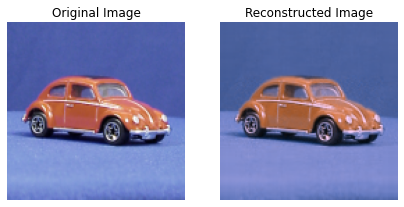

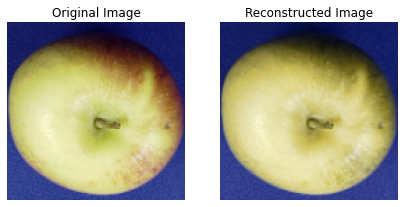

In [11]:
# car
# Evaluate result
tensor_res_car = residual_tensor(tensor_car, tensor_tkd_car)
rel_error_car = tensor_res_car.frob_norm / tensor_car.frob_norm

print("Relative error of approximation (car) = {}".format(rel_error_car))

# Reconstruction
tensor_rec_car = tensor_tkd_car.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_car, tensor_rec_car)


# apple
# Evaluate result
tensor_res_apple = residual_tensor(tensor_apple, tensor_tkd_apple)
rel_error_apple = tensor_res_apple.frob_norm / tensor_apple.frob_norm

print("Relative error of approximation (apple) = {}".format(rel_error_apple))

# Reconstruction
tensor_rec_apple = tensor_tkd_apple.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_apple, tensor_rec_apple)

The HOOI algorithm with a multi-linear rank of (50, 50, 2) is used for the Tucker representation of the figures with tensor of size (128, 128, 3). In this case, the elements in the tensor are decreased from 49152 to 5000, which is a great saving in the complexity under the cost of resolution. As shown in the result, the resolution of the reconstructed figures is lower than the original ones but is acceptable. 

Besides, there exists some difference between the colour of the results and original figures. Not only the size used to represent the figures in the reconstruction is changed, but the number used to represent the colour is decreased from 3 to 2. This means that only the two most significant components among the three colours R, G, and B are taken to represent the figure, while the least significant component is ignored. This can be clearly observed in the apple figures, where there is almost no red in the reconstructed figure.

The approximation errors of the two figures are about 4%. Comparing the decrease in elements from 49152 to 5000, it is shown that the Tucker decomposition performs well in data compression.

### Solution: Part 2

In [12]:
# Create tensors from images

# From the top
top = get_image(item="apple", view="top")
tensor_top = Tensor(top)

# For the side
side = get_image(item="apple", view="side")
tensor_side = Tensor(side)

In [13]:
# Perform decomposition

algorithm = HOSVD()
rank = (50, 50, 2)

tensor_tkd_top = algorithm.decompose(tensor_top, rank)  # From the top
tensor_tkd_side = algorithm.decompose(tensor_side, rank)  # For the side

Relative error of approximation (apple top) = 0.03706225838740832
Relative error of approximation (apple side) = 0.06574690406026354


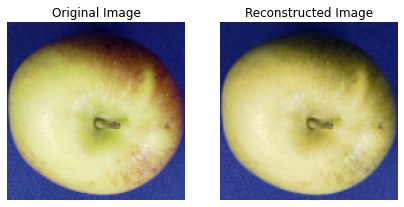

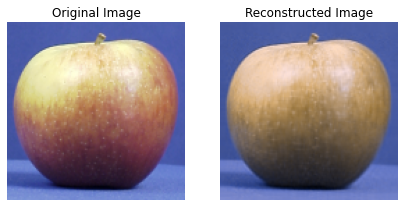

In [14]:
# From the top
# Evaluate result
tensor_res_top = residual_tensor(tensor_top, tensor_tkd_top)
rel_error_top = tensor_res_top.frob_norm / tensor_top.frob_norm

print("Relative error of approximation (apple top) = {}".format(rel_error_top))

# Reconstruction
tensor_rec_top = tensor_tkd_top.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_top, tensor_rec_top)


# For the side
# Evaluate result
tensor_res_side = residual_tensor(tensor_side, tensor_tkd_side)
rel_error_side = tensor_res_side.frob_norm / tensor_side.frob_norm

print("Relative error of approximation (apple side) = {}".format(rel_error_side))
# Reconstruction
tensor_rec_side = tensor_tkd_side.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_side, tensor_rec_side)

As mentioned before, only the two most significant components among the three colours R, G, and B are taken to represent the figure. For the top view, the two most significant components are G and B, hence R is ignored. It is shown that there is no red colour in the reconstructed figure. As for the side view, it is hard to say which components are the most significant ones. As shown in the figure, the colour in the background is slightly darker, while the colour of the apple becomes brown. In addition, the approximation error of the side view is almost twice higher than that of the top view. This shows that if there does not exist one or two most significant colours, it is hard for this method to reconstruct figures with similar colours as original figures.

### Solution: Part 3

If only 1 rank is used to approximate the three colours, the colour in the reconstructed figure significantly changes. It performs like a grey level image while still contain the most significant colour. In this case, the approximation error increases dramatically, which is mainly caused by the difference in colour. 

Relative error of approximation (apple top) = 0.16727962973903554
Relative error of approximation (apple side) = 0.2251191410550059


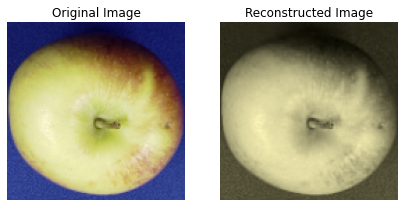

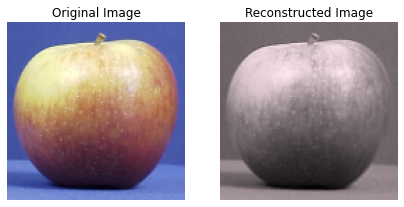

In [15]:
# Create tensors from images

# From the top
top = get_image(item="apple", view="top")
tensor_top = Tensor(top)

# For the side
side = get_image(item="apple", view="side")
tensor_side = Tensor(side)


# Perform decomposition
algorithm = HOSVD()
rank = (50, 50, 1)

tensor_tkd_top = algorithm.decompose(tensor_top, rank)  # From the top
tensor_tkd_side = algorithm.decompose(tensor_side, rank)  # For the side


# From the top
# Evaluate result
tensor_res_top = residual_tensor(tensor_top, tensor_tkd_top)
rel_error_top = tensor_res_top.frob_norm / tensor_top.frob_norm

print("Relative error of approximation (apple top) = {}".format(rel_error_top))

# Reconstruction
tensor_rec_top = tensor_tkd_top.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_top, tensor_rec_top)


# For the side
# Evaluate result
tensor_res_side = residual_tensor(tensor_side, tensor_tkd_side)
rel_error_side = tensor_res_side.frob_norm / tensor_side.frob_norm

print("Relative error of approximation (apple side) = {}".format(rel_error_side))
# Reconstruction
tensor_rec_side = tensor_tkd_side.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor_side, tensor_rec_side)